In [36]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from src.groupkfold import GroupKFoldWithSeed
from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.005
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.9
    bagging_freq: 1
    feature_fraction: 0.9
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 500
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '004'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/004/base
seed: 42
n_splits: 5
target: Recommended IND



### Import

In [37]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")
train_test_df = pl.concat([train_df, test_df], how="diagonal")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,str,str,str
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts"""
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts"""
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts"""
0,45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts"""
0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts"""


### 特徴量加工

In [38]:
# テキストデータ由来の特徴量

# CountVectorizer + 次元削減

count_svd = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=cfg.seed)),
    ]
)

count_nmf = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("NMF", NMF(n_components=50, random_state=cfg.seed)),
    ]
)

count_lda = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("LDA", LatentDirichletAllocation(n_components=50, random_state=cfg.seed)),
    ]
)

title_features_count_svd = count_svd.fit_transform(train_test_df["Title"].fill_null(""))
title_features_count_nmf = count_nmf.fit_transform(train_test_df["Title"].fill_null(""))
title_features_count_lda = count_lda.fit_transform(train_test_df["Title"].fill_null(""))

review_text_features_count_svd = count_svd.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_count_nmf = count_nmf.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_count_lda = count_lda.fit_transform(train_test_df["Review Text"].fill_null(""))


In [39]:
# TfidfVectorizer + 次元削減

tfidf_svd = Pipeline(
    steps=[
        ("TfidfVectorizer", TfidfVectorizer()),
        ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=cfg.seed)),
    ]
)

tfidf_nmf = Pipeline(
    steps=[("TfidfVectorizer", TfidfVectorizer()), ("NMF", NMF(n_components=50, random_state=cfg.seed))]
)

tfidf_lda = Pipeline(
    steps=[
        ("TfidfVectorizer", TfidfVectorizer()),
        ("LDA", LatentDirichletAllocation(n_components=50, random_state=cfg.seed)),
    ]
)

title_features_tfidf_svd = tfidf_svd.fit_transform(train_test_df["Title"].fill_null(""))
title_features_tfidf_nmf = tfidf_nmf.fit_transform(train_test_df["Title"].fill_null(""))
title_features_tfidf_lda = tfidf_lda.fit_transform(train_test_df["Title"].fill_null(""))

review_text_features_tfidf_svd = tfidf_svd.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_tfidf_nmf = tfidf_nmf.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_tfidf_lda = tfidf_lda.fit_transform(train_test_df["Review Text"].fill_null(""))


In [40]:
# 特徴量をデータフレームに変換してtrain_test_dfに結合

title_features_count_svd_df = pl.DataFrame(title_features_count_svd).rename(
    {col: f"title_count_svd_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_svd).columns)}
)

title_features_count_nmf_df = pl.DataFrame(title_features_count_nmf).rename(
    {col: f"title_count_nmf_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_nmf).columns)}
)

title_features_count_lda_df = pl.DataFrame(title_features_count_lda).rename(
    {col: f"title_count_lda_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_lda).columns)}
)

title_features_tfidf_svd_df = pl.DataFrame(title_features_tfidf_svd).rename(
    {col: f"title_tfidf_svd_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_svd).columns)}
)

title_features_tfidf_nmf_df = pl.DataFrame(title_features_tfidf_nmf).rename(
    {col: f"title_tfidf_nmf_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_nmf).columns)}
)

title_features_tfidf_lda_df = pl.DataFrame(title_features_tfidf_lda).rename(
    {col: f"title_tfidf_lda_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_lda).columns)}
)

review_text_features_count_svd_df = pl.DataFrame(review_text_features_count_svd).rename(
    {col: f"review_text_count_svd_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_svd).columns)}
)

review_text_features_count_nmf_df = pl.DataFrame(review_text_features_count_nmf).rename(
    {col: f"review_text_count_nmf_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_nmf).columns)}
)

review_text_features_count_lda_df = pl.DataFrame(review_text_features_count_lda).rename(
    {col: f"review_text_count_lda_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_lda).columns)}
)

review_text_features_tfidf_svd_df = pl.DataFrame(review_text_features_tfidf_svd).rename(
    {col: f"review_text_tfidf_svd_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_svd).columns)}
)

review_text_features_tfidf_nmf_df = pl.DataFrame(review_text_features_tfidf_nmf).rename(
    {col: f"review_text_tfidf_nmf_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_nmf).columns)}
)

review_text_features_tfidf_lda_df = pl.DataFrame(review_text_features_tfidf_lda).rename(
    {col: f"review_text_tfidf_lda_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_lda).columns)}
)

train_test_df = pl.concat(
    [
        train_test_df,
        title_features_count_svd_df,
        title_features_count_nmf_df,
        title_features_count_lda_df,
        title_features_tfidf_svd_df,
        title_features_tfidf_nmf_df,
        title_features_tfidf_lda_df,
        review_text_features_count_svd_df,
        review_text_features_count_nmf_df,
        review_text_features_count_lda_df,
        review_text_features_tfidf_svd_df,
        review_text_features_tfidf_nmf_df,
        review_text_features_tfidf_lda_df,
    ],
    how="horizontal",
)




In [41]:
train_test_df


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
i64,i64,str,str,i64,i64,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",0.025195,-0.00648,0.012603,0.003141,0.012205,-0.000844,0.005959,0.010225,0.010628,-0.016433,0.011628,-0.046988,0.037764,-0.007302,0.002619,0.015284,0.018744,0.004656,-0.013711,-0.037262,-0.011599,-0.004719,0.027288,0.025759,0.048784,0.032718,0.014947,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098686,0.072571,-0.328555,-0.013497,-0.100252,-0.006362,0.35835,0.416802,0.373022,0.431635,-0.048531,-0.004923,0.000447,-0.218991,0.250992,-0.072074,0.059355,0.084027,-0.361555,0.063103,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.750185,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.039275,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.082819,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624297,0.276107,0.462861,-0.336008,-0.553737,0.222199,-0.241237,0.069381,0.040903,0.555153,-0.216711,-0.109355,-0.104412,0.029977,-0.0244,0.053208,-0.213489,-0.001591,-0.054637,-0.030146,0.099794,0.009727,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.795935,0.002375,0.002375,0.04731,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375
0,45,null,"""I was really pleased with this…",

In [42]:
# ラベルエンコーディング

le_division_name = LabelEncoder()
le_division_name.fit(cloth_df["Division Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_division_name.transform(train_test_df["Division Name"])).alias("Division Name")
)

le_department_name = LabelEncoder()
le_department_name.fit(cloth_df["Department Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_department_name.transform(train_test_df["Department Name"])).alias("Department Name")
)

le_class_name = LabelEncoder()
le_class_name.fit(cloth_df["Class Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_class_name.transform(train_test_df["Class Name"])).alias("Class Name")
)


In [43]:
display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,0.025195,-0.00648,0.012603,0.003141,0.012205,-0.000844,0.005959,0.010225,0.010628,-0.016433,0.011628,-0.046988,0.037764,-0.007302,0.002619,0.015284,0.018744,0.004656,-0.013711,-0.037262,-0.011599,-0.004719,0.027288,0.025759,0.048784,0.032718,0.014947,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098686,0.072571,-0.328555,-0.013497,-0.100252,-0.006362,0.35835,0.416802,0.373022,0.431635,-0.048531,-0.004923,0.000447,-0.218991,0.250992,-0.072074,0.059355,0.084027,-0.361555,0.063103,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.750185,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.039275,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.082819,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624297,0.276107,0.462861,-0.336008,-0.553737,0.222199,-0.241237,0.069381,0.040903,0.555153,-0.216711,-0.109355,-0.104412,0.029977,-0.0244,0.053208,-0.213489,-0.001591,-0.054637,-0.030146,0.099794,0.009727,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.795935,0.002375,0.002375,0.04731,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375
0,45,null,"""I was really pleased with this…",5,1,9,0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [44]:
# テキストデータの長さ特徴量
train_test_df = train_test_df.with_columns(
    pl.col("Title").str.len_bytes().alias("title_str_len"),
    pl.col("Review Text").str.len_bytes().alias("review_text_str_len"),
)

display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,…,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49,title_str_len,review_text_str_len
i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,0.025195,-0.00648,0.012603,0.003141,0.012205,-0.000844,0.005959,0.010225,0.010628,-0.016433,0.011628,-0.046988,0.037764,-0.007302,0.002619,0.015284,0.018744,0.004656,-0.013711,-0.037262,-0.011599,-0.004719,0.027288,0.025759,0.048784,0.032718,0.014947,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,15,185
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098686,0.072571,-0.328555,-0.013497,-0.100252,-0.006362,0.35835,0.416802,0.373022,0.431635,-0.048531,-0.004923,0.000447,-0.218991,0.250992,-0.072074,0.059355,0.084027,-0.361555,0.063103,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.750185,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.039275,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.082819,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,9,285
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624297,0.276107,0.462861,-0.336008,-0.553737,0.222199,-0.241237,0.069381,0.040903,0.555153,-0.216711,-0.109355,-0.104412,0.029977,-0.0244,0.053208,-0.213489,-0.001591,-0.054637,-0.030146,0.099794,0.009727,…,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.795935,0.002375,0.002375,0.04731,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,50,495
0,45,null,"""I was really pleased with this…",5,1,9,0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.00273,0.00273,0.00273,0.002

In [45]:
# 集約特徴量

# Clothing ID毎の集約特徴量
cloth_id_cols = ["Age", "Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_cloth_id_max = [pl.col(col).max().over("Clothing ID").name.suffix("_cloth_id_max") for col in cloth_id_cols]
exprs_cloth_id_min = [pl.col(col).min().over("Clothing ID").name.suffix("_cloth_id_min") for col in cloth_id_cols]
exprs_cloth_id_mean = [pl.col(col).mean().over("Clothing ID").name.suffix("_cloth_id_mean") for col in cloth_id_cols]
exprs_cloth_id_sum = [pl.col(col).sum().over("Clothing ID").name.suffix("_cloth_id_sum") for col in cloth_id_cols]

# age毎の集約特徴量
age_cols = ["Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_age_max = [pl.col(col).max().over("Age").name.suffix("_age_max") for col in age_cols]
exprs_age_min = [pl.col(col).min().over("Age").name.suffix("_age_min") for col in age_cols]
exprs_age_mean = [pl.col(col).mean().over("Age").name.suffix("_age_mean") for col in age_cols]
exprs_age_sum = [pl.col(col).sum().over("Age").name.suffix("_age_sum") for col in age_cols]

# Positive Feedback Count毎の集約特徴量
positive_feedback_count_cols = ["Age", "title_str_len", "review_text_str_len"]
exprs_positive_feedback_count_max = [
    pl.col(col).max().over("Positive Feedback Count").name.suffix("_positive_feedback_count_max")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_min = [
    pl.col(col).min().over("Positive Feedback Count").name.suffix("_positive_feedback_count_min")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_mean = [
    pl.col(col).mean().over("Positive Feedback Count").name.suffix("_positive_feedback_count_mean")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_sum = [
    pl.col(col).sum().over("Positive Feedback Count").name.suffix("_positive_feedback_count_sum")
    for col in positive_feedback_count_cols
]


train_test_df = train_test_df.with_columns(
    exprs_cloth_id_max
    + exprs_cloth_id_min
    + exprs_cloth_id_mean
    + exprs_cloth_id_sum
    + exprs_age_max
    + exprs_age_min
    + exprs_age_mean
    + exprs_age_sum
    + exprs_positive_feedback_count_max
    + exprs_positive_feedback_count_min
    + exprs_positive_feedback_count_mean
    + exprs_positive_feedback_count_sum
)


In [46]:
display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,0.025195,-0.00648,0.012603,0.003141,0.012205,-0.000844,0.005959,0.010225,0.010628,-0.016433,0.011628,-0.046988,0.037764,-0.007302,0.002619,0.015284,0.018744,0.004656,-0.013711,-0.037262,-0.011599,-0.004719,0.027288,0.025759,0.048784,0.032718,0.014947,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,30,50,502,0,4,44,1.711268,19.270833,311.561265,486,4625,78825,99,52,504,19,2,41,44.336957,19.679167,349.969292,36711,14169,262127
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098686,0.072571,-0.328555,-0.013497,-0.100252,-0.006362,0.35835,0.416802,0.373022,0.431635,-0.048531,-0.004923,0.000447,-0.218991,0.250992,-0.072074,0.059355,0.084027,-0.361555,0.063103,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,94,50,504,0,2,41,2.860384,18.362,328.427711,3278,18362,327114,94,52,508,18,2,9,42.443438,18.304348,276.704659,426217,147350,2328193
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624297,0.276107,0.462861,-0.336008,-0.553737,0.222199,-0.241237,0.069381,0.040903,0.555153,-0.216711,-0.109355,-0.104412,0.029977,-0.0244,0.053208,-0.213489,-0.001591,-0.054637,-0.030146,0.099794,0.009727,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,68,50,505,0,3,41,2.828619,19.009766,314.478927,1700,9733,164158,83,50,506,20,2,52,44.471667,20.203095,356.972727,26683,10445,196335
0,45,null,"""I was really pleased with this…",5,1,9,0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,65,51,502,0,3,36,2.341513,1

### 学習

In [47]:
train_df = train_test_df.filter(pl.col("Rating").is_not_null())
test_df = train_test_df.filter(pl.col("Rating").is_null()).drop(["Rating", cfg.target])

display(train_df.head())
display(test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,0.025195,-0.00648,0.012603,0.003141,0.012205,-0.000844,0.005959,0.010225,0.010628,-0.016433,0.011628,-0.046988,0.037764,-0.007302,0.002619,0.015284,0.018744,0.004656,-0.013711,-0.037262,-0.011599,-0.004719,0.027288,0.025759,0.048784,0.032718,0.014947,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,30,50,502,0,4,44,1.711268,19.270833,311.561265,486,4625,78825,99,52,504,19,2,41,44.336957,19.679167,349.969292,36711,14169,262127
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098686,0.072571,-0.328555,-0.013497,-0.100252,-0.006362,0.35835,0.416802,0.373022,0.431635,-0.048531,-0.004923,0.000447,-0.218991,0.250992,-0.072074,0.059355,0.084027,-0.361555,0.063103,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,94,50,504,0,2,41,2.860384,18.362,328.427711,3278,18362,327114,94,52,508,18,2,9,42.443438,18.304348,276.704659,426217,147350,2328193
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624297,0.276107,0.462861,-0.336008,-0.553737,0.222199,-0.241237,0.069381,0.040903,0.555153,-0.216711,-0.109355,-0.104412,0.029977,-0.0244,0.053208,-0.213489,-0.001591,-0.054637,-0.030146,0.099794,0.009727,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,68,50,505,0,3,41,2.828619,19.009766,314.478927,1700,9733,164158,83,50,506,20,2,52,44.471667,20.203095,356.972727,26683,10445,196335
0,45,null,"""I was really pleased with this…",5,1,9,0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,65,51,502,0,3,36,2.341513,1

Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,title_count_svd_27,title_count_svd_28,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,32,"""So happy i bought this skirt!""","""I love this skirt. it does run…",0,0,0,12,0.320644,0.150524,-0.014631,0.058547,-0.00579,0.095297,-0.045547,0.109254,-0.097353,0.131938,-0.399765,-0.29103,1.114799,0.079006,-0.155604,-0.170691,-0.104622,-0.280993,0.201487,-0.311464,-0.129152,-0.00527,0.086633,-0.036366,0.004847,-0.094398,0.024497,-0.123383,-0.026106,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,34,50,502,0,3,25,1.888496,18.432018,293.377282,1067,8405,144635,94,52,508,18,2,9,42.443438,18.304348,276.704659,426217,147350,2328193
0,34,"""Runs small""","""Beautiful patterns and colors,…",0,0,0,12,0.079538,-0.073515,-0.023258,-0.073754,-0.040477,0.01668,0.098195,-0.082898,0.068851,0.133195,0.071514,-0.155286,0.016917,0.165985,0.634824,0.3864,-0.546859,-0.289767,0.043733,-0.082855,0.276407,-0.583382,0.123317,-0.086825,-0.085133,0.227661,-0.003559,-0.052915,-0.027695,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,122,50,504,0,2,37,3.090529,20.440336,308.742351,2219,12162,191729,94,52,508,18,2,9,42.443438,18.304348,276.704659,426217,147350,2328193
0,37,"""Love the comfort of thi skirt""","""It is easily paired with a nic…",0,0,0,12,0.794219,0.684315,-0.107944,-0.072856,0.177418,-0.267058,-0.145139,0.141073,0.805209,-0.180223,0.005613,-0.125746,-0.24245,0.152111,-0.049783,-0.128303,0.060569,-0.19,-0.121533,0.003246,-0.015388,-0.014086,0.059868,0.019138,0.076717,0.070517,0.001292,-0.101768,0.061715,…,502,25,0,9,16,45.285714,2.809524,21.941176,321.117647,951,59,373,5459,89,52,504,0,2,29,2.576867,18.450805,298.094178,1760,10314,174087,94,52,508,18,2,9,42.443438,18.304348,276.704659,426217,147350,2328193
0,39,"""Way too small""","""This is a beautiful skirt, but…",10,0,0,12,0.087626,-0.073046,-0.032427,-0.082472,-0.017544,-0.037804,0.047415,-0.058425,0.079528,0.112872,0.058868,-0.12

In [48]:
x_train = train_df.drop([cfg.target, "Rating", "Title", "Review Text"]).to_pandas()
y_train = train_df[cfg.target].to_pandas()

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
cvbooster.save_model(f"{cfg.data.results_dir}/model.pkl")


Training until validation scores don't improve for 500 rounds
[100]	cv_agg's valid auc: 0.888361 + 0.00782851
[200]	cv_agg's valid auc: 0.897482 + 0.00732739
[300]	cv_agg's valid auc: 0.903415 + 0.00647363
[400]	cv_agg's valid auc: 0.908 + 0.00610535
[500]	cv_agg's valid auc: 0.912168 + 0.0057447
[600]	cv_agg's valid auc: 0.915285 + 0.00532647
[700]	cv_agg's valid auc: 0.918542 + 0.0049459
[800]	cv_agg's valid auc: 0.920713 + 0.00474927
[900]	cv_agg's valid auc: 0.922562 + 0.00466986
[1000]	cv_agg's valid auc: 0.924023 + 0.00466569
[1100]	cv_agg's valid auc: 0.92531 + 0.00461793
[1200]	cv_agg's valid auc: 0.926353 + 0.00446988
[1300]	cv_agg's valid auc: 0.927068 + 0.00440503
[1400]	cv_agg's valid auc: 0.927761 + 0.00442865
[1500]	cv_agg's valid auc: 0.92833 + 0.0041898
[1600]	cv_agg's valid auc: 0.928772 + 0.00414667
[1700]	cv_agg's valid auc: 0.929152 + 0.0041999
[1800]	cv_agg's valid auc: 0.929593 + 0.00413034
[1900]	cv_agg's valid auc: 0.929902 + 0.00412428
[2000]	cv_agg's valid auc

### log

In [49]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid auc-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid auc-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score (auc): {best_score}\n")
    log_file.write(f"best_score_stdv (auc): {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

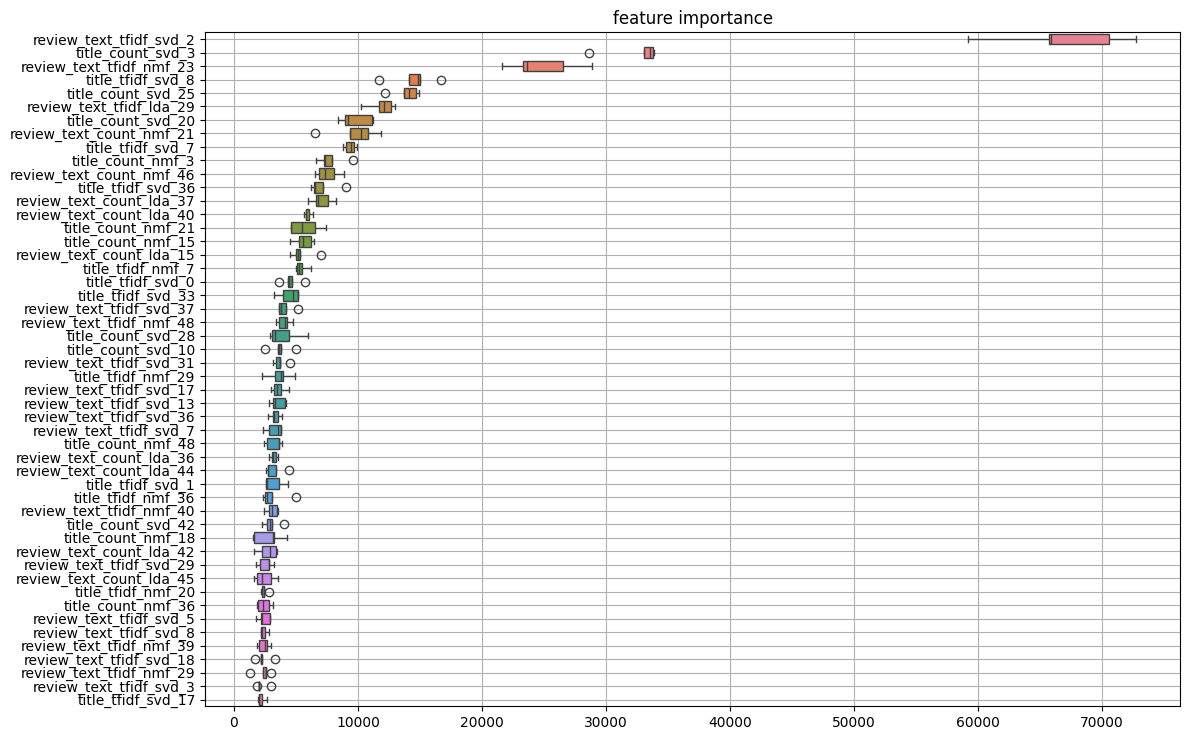

In [50]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

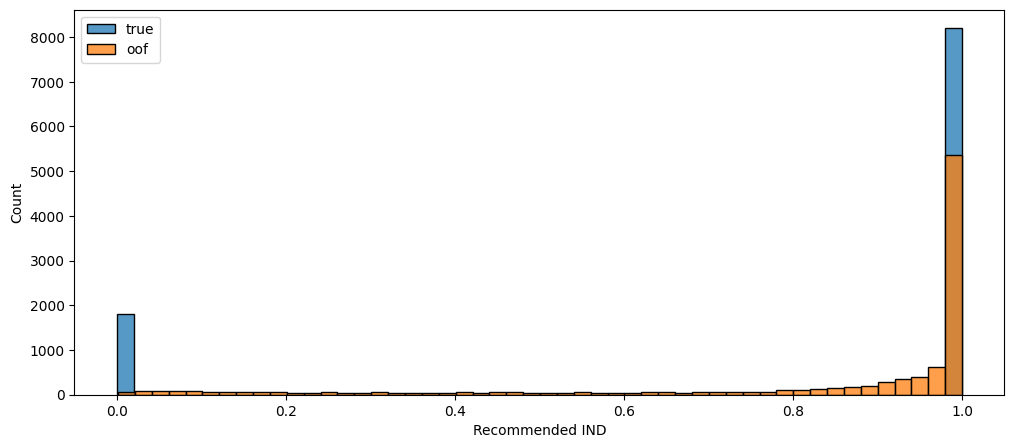

In [51]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(skf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [52]:
# 推論
x_test = test_df.drop(["Title", "Review Text"]).to_pandas()
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,target
0,0.997521
1,0.792693
2,0.999040
3,0.488727
4,0.983257
